<center>
<h1> SOLUCIÓN TAREA 12 - Movimiento en imágenes
</h1>
<h3>Diego Godoy Rojas & Luis Carlos Diaz </h3>
</center>

Importamos las librerias necesarias para trabajar:

In [13]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2

# ALGORITMO DE FLUJO ÓPTICO POR EL MÉTODO DIFERENCIAL

inRange comprueba si las coordenadas dadas se alinean en los límites de la imagen dados coordenadas, los límites son tuplas, es decir, (X,Y):

In [14]:
def inRange( cordinates, limits):
    x,y = cordinates
    X_Limit, Y_Limit = limits
    return 0 <= x and x < X_Limit and 0 <= y and y < Y_Limit

OpticalFlow calcula los desplazamientos en las direcciones X e Y, es decir, (u,v) dadas dos imágenes consecutivas que varían con el tiempo:

In [15]:
def optical_flow(old_frame, new_frame, window_size, min_quality=0.01):

    max_corners = 10000
    min_distance = 0.1
    feature_list = cv2.goodFeaturesToTrack(old_frame, max_corners, min_quality, min_distance)

    w = int(window_size/2)

    old_frame = old_frame / 255
    new_frame = new_frame / 255

    # Obtener los gradientes en las dimensiones X, Y y T
    kernel_x = np.array([[-1, 1], [-1, 1]])
    kernel_y = np.array([[-1, -1], [1, 1]])
    kernel_t = np.array([[1, 1], [1, 1]])

    fx = cv2.filter2D(old_frame, -1, kernel_x)              #Gradiente sobre X
    fy = cv2.filter2D(old_frame, -1, kernel_y)              #Gradiente sobre Y
    ft = cv2.filter2D(new_frame, -1, kernel_t) - cv2.filter2D(old_frame, -1, kernel_t)  #Gradiente sobre el tiempo


    u = np.zeros(old_frame.shape)
    v = np.zeros(old_frame.shape)

    for feature in feature_list:        # para cada esquina
            j, i = feature.ravel()      # obtener las coordenadas de las esquinas (i,j). Se almacenan en el orden j, i
            i, j = int(i), int(j)       # i,j son flotantes inicialmente

            I_x = fx[i-w:i+w+1, j-w:j+w+1].flatten()
            I_y = fy[i-w:i+w+1, j-w:j+w+1].flatten()
            I_t = ft[i-w:i+w+1, j-w:j+w+1].flatten()

            b = np.reshape(I_t, (I_t.shape[0],1))
            A = np.vstack((I_x, I_y)).T

            U = np.matmul(np.linalg.pinv(A), b)     # Resolver para (u,v) es decir, U

            u[i,j] = U[0][0]
            v[i,j] = U[1][0]
 
    return (u,v)

Dibujamos los vectores de desplazamiento en la imagen dados (u,v):

In [16]:
def drawOnFrame(frame, U, V):

    line_color = (0, 255, 0) #  Verde

    for i in range(frame.shape[0]):
        for j in range(frame.shape[1]):
            u, v = U[i][j], V[i][j]

            if u and v:
                frame = cv2.arrowedLine( frame, (i, j), (int(round(i+u)), int(round(j+v))),
                                        (0, 255, 0),
                                        thickness=1
                                    )
    plt.imshow(frame)

Creamos un gráfico de los vectores de desplazamiento dados (u,v) y traza las dos imágenes y el desplazamiento en una fila:

In [17]:
def drawSeperately(old_frame, new_frame, U, V):

    displacement = np.ones_like(img2)
    displacement.fill(255.)             # Rellena el gráfico de desplazamiento con fondo blanco
    line_color =  (0, 0, 0)
    # Dibuja los vectores de desplazamiento
    for i in range(img2.shape[0]):
        for j in range(img2.shape[1]):

            start_pixel = (i,j)
            end_pixel = ( int(i+U[i][j]), int(j+V[i][j]) )

            # Comprobar si hay desplazamiento para la esquina y el punto final está en el rango
            if U[i][j] and V[i][j] and inRange( end_pixel, img1.shape ):     
                displacement = cv2.arrowedLine( displacement, start_pixel, end_pixel, line_color, thickness =2)

    figure, axes = plt.subplots(1,3,figsize=(15,15))
    axes[0].imshow(old_frame, cmap = "gray")
    axes[0].set_title("Primera imagen")
    axes[1].imshow(new_frame, cmap = "gray")
    axes[1].set_title("Segunda imagen")
    axes[2].imshow(displacement, cmap = "gray")
    axes[2].set_title("Desplazamiento")
    figure.tight_layout()
    plt.show()

Realizamos las pruebas para dos imagenes diferentes:

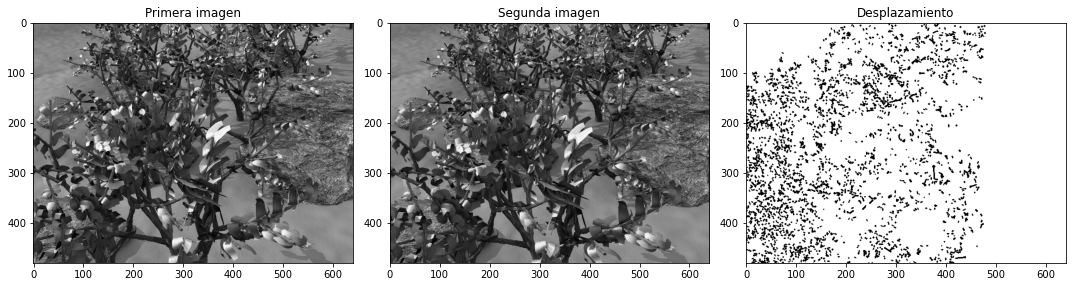

In [18]:
# imagenes de entrada
img1 = cv2.imread("grove1.png")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

img2 = cv2.imread("grove2.png")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Obtener (u,v) a partir del enfoque de flujo óptico diferencial
U, V = optical_flow( img1, img2, 3, 0.05)

img2 = cv2.cvtColor( img2, cv2.COLOR_GRAY2RGB)

drawSeperately(img1, img2, U, V)

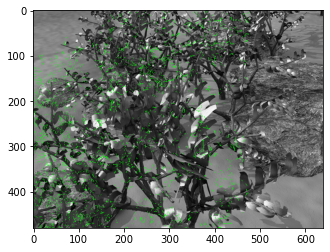

In [19]:
drawOnFrame(img2, U, V)

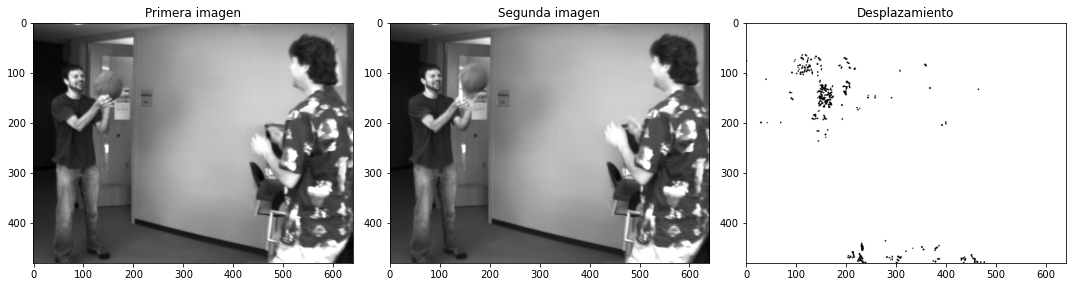

In [20]:
# Imagenes de entrada
img1 = cv2.imread("basketball1.png")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

img2 = cv2.imread("basketball2.png")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Obtener (u,v) a partir del enfoque de flujo óptico diferencial
U, V = optical_flow( img1, img2, 3, 0.02)
# Save results
img2 = cv2.cvtColor( img2, cv2.COLOR_GRAY2RGB)

drawSeperately(img1, img2, U, V)

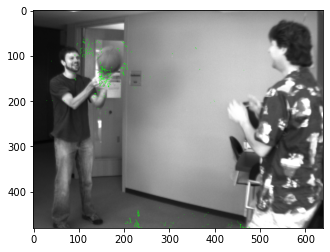

In [21]:
drawOnFrame(img2, U, V)

Podemos observar el adecuado funcionamiento del algoritmo de flujo optico para dos imagenes sucesivas, donde podemos observar el movimiento y variación que existe entre ambas.

# Implementación filtro de Kalman

Definimos el filtro de Kalman empleando lo visto en las presentaciones de la clase:

In [22]:
class KalmanFilter(object):
    def __init__(self, dt, u_x,u_y, std_acc, x_std_meas, y_std_meas):
        """
        :param dt: Tiempo de muestreo (tiempo para 1 ciclo)
        :param u_x: aceleración en dirección x
        :param u_y: aceleración en dirección y
        :param std_acc: magnitud del ruido del proceso
        :param x_std_meas: desviación estándar de la medición en la dirección x
        :param y_std_meas: desviación estándar de la medición en la dirección y
        """

        # Definir el tiempo de muestreo
        self.dt = dt

        # Define las variables de entrada de control
        self.u = np.matrix([[u_x],[u_y]])

        # Estado inicial
        self.x = np.matrix([[0], [0], [0], [0]])

        # Definir la matriz de transición de estado A
        self.A = np.matrix([[1, 0, self.dt, 0],
                            [0, 1, 0, self.dt],
                            [0, 0, 1, 0],
                            [0, 0, 0, 1]])

        # Definir la matriz de entrada de control B
        self.B = np.matrix([[(self.dt**2)/2, 0],
                            [0,(self.dt**2)/2],
                            [self.dt,0],
                            [0,self.dt]])

        # Definir la matriz de mapeo de medidas
        self.H = np.matrix([[1, 0, 0, 0],
                            [0, 1, 0, 0]])

        # Covarianza del ruido del proceso inicial
        self.Q = np.matrix([[(self.dt**4)/4, 0, (self.dt**3)/2, 0],
                            [0, (self.dt**4)/4, 0, (self.dt**3)/2],
                            [(self.dt**3)/2, 0, self.dt**2, 0],
                            [0, (self.dt**3)/2, 0, self.dt**2]]) * std_acc**2

        # Covarianza del ruido de la medición inicial
        self.R = np.matrix([[x_std_meas**2,0],
                           [0, y_std_meas**2]])

        # Matriz de covarianza inicial
        self.P = np.eye(self.A.shape[1])

    def predict(self):
        # Eq.(9) and Eq.(10) in:
        # https://machinelearningspace.com/object-tracking-simple-implementation-of-kalman-filter-in-python/?preview_id=1364&preview_nonce=52f6f1262e&preview=true&_thumbnail_id=1795

        # Actualiza el estado del tiempo
        #x_k =Ax_(k-1) + Bu_(k-1)     Eq.(9)
        self.x = np.dot(self.A, self.x) + np.dot(self.B, self.u)

        # Calcular la covarianza del error
        # P= A*P*A' + Q               Eq.(10)
        self.P = np.dot(np.dot(self.A, self.P), self.A.T) + self.Q
        return self.x[0:2]

    def update(self, z):

        # Refer to :Eq.(11), Eq.(12) and Eq.(13) in_
        # https://machinelearningspace.com/object-tracking-simple-implementation-of-kalman-filter-in-python/?preview_id=1364&preview_nonce=52f6f1262e&preview=true&_thumbnail_id=1795
        # S = H*P*H'+R
        S = np.dot(self.H, np.dot(self.P, self.H.T)) + self.R

        # Calcular la ganancia de Kalman
        # K = P * H'* inv(H*P*H'+R)
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))  #Eq.(11)

        self.x = np.round(self.x + np.dot(K, (z - np.dot(self.H, self.x))))   #Eq.(12)

        I = np.eye(self.H.shape[1])

        # Actualizar la matriz de covarianza del error
        self.P = (I - (K * self.H)) * self.P   #Eq.(13)
        return self.x[0:2]

Definimos la función para llevar acabo la detección:

In [23]:
def detect(frame,debugMode):
    # Convierte el fotograma de BGR a GRIS
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    if (debugMode):
        cv2.imshow('gray', gray)

    # Detección de bordes usando la función Canny
    img_edges = cv2.Canny(gray,  50, 190, 3)
    if (debugMode):
        cv2.imshow('img_edges', img_edges)

    # Convertir a imagen en blanco y negro
    ret, img_thresh = cv2.threshold(img_edges, 254, 255,cv2.THRESH_BINARY)
    if (debugMode):
        cv2.imshow('img_thresh', img_thresh)

    # Encontrar los contornos
    contours, _ = cv2.findContours(img_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Establecer el radio mínimo y máximo aceptado de un objeto detectado
    min_radius_thresh= 3
    max_radius_thresh= 30

    centers=[]
    for c in contours:
        # https://docs.opencv.org/trunk/dd/d49/tutorial_py_contour_features.html
        (x, y), radius = cv2.minEnclosingCircle(c)
        radius = int(radius)

        #Toma sólo los círculos válidos
        if (radius > min_radius_thresh) and (radius < max_radius_thresh):
            centers.append(np.array([[x], [y]]))
    cv2.imshow('contours', img_thresh)
    return centers

Realizamos un ejemplo con un video de prueba:

(Profe las ventanas de los videos se cierran dando clic en ellas y oprimiendo q, fue la unica forma que encontramos)

In [24]:
# Crear objeto de captura de vídeo opencv
VideoCap = cv2.VideoCapture('video.avi')

#Variable utilizada para controlar la velocidad de lectura del video
ControlSpeedVar = 50  #Lowest: 1 - Highest:100

HiSpeed = 100

#Crear el objeto KalmanFilter KF
#KalmanFilter(dt, u_x, u_y, std_acc, x_std_meas, y_std_meas)

KF = KalmanFilter(0.1, 1, 1, 1, 0.1,0.1)

debugMode=1

while(True):
    # Leer fotograma
    ret, frame = VideoCap.read()

    # Detectar el objeto
    centers = detect(frame,debugMode)

    # Si se detectan los centros, entonces rastrearlos
    if (len(centers) > 0):

        # Dibuja el círculo detectado
        cv2.circle(frame, (int(centers[0][0]), int(centers[0][1])), 10, (0, 191, 255), 2)

        # Predecir
        (x, y) = KF.predict()
        x,y=(x,y)
        x,y=int(x),int(y)
        # Dibuja un rectángulo como la posición del objeto predicho
        cv2.rectangle(frame, (x - 15, y - 15), (x + 15, y + 15), (255, 0, 0), 2)

        # Actualizar
        (x1, y1) = KF.update(centers[0])
        x1,y1=(x1,y1)
        x1,y1=int(x1),int(y1)

        # Dibuja un rectángulo como la posición estimada del objeto
        cv2.rectangle(frame, (x1 - 15, y1 - 15), (x1 + 15, y1 + 15), (0, 0, 255), 2)
        cv2.putText(frame, "Estimated Position", (x1 + 15, y1 + 10), 0, 0.5, (0, 0, 255), 2)
        cv2.putText(frame, "Predicted Position", (x + 15, y), 0, 0.5, (255, 0, 0), 2)
        cv2.putText(frame, "Measured Position", (int(centers[0][0]) + 15, int(centers[0][1]) - 15), 0, 0.5, (0,191,255), 2)

    cv2.imshow('image', frame)

    if cv2.waitKey(2) & 0xFF == ord('q'):
        VideoCap.release()
        cv2.destroyAllWindows()
        break

    cv2.waitKey(HiSpeed-ControlSpeedVar+1)